Throughout the following exercises, you will learn to use Python to construct and interpret an XGBoost classification model using the XGBoost modeling library. Before starting on this programming exercise, we strongly recommend watching the video lecture and completing the IVQ for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

Topics of focus include:

- Relevant import statements
- Fitting a model
- Using GridSearchCV to cross-validate the model and tune the following hyperparameters:
    - max_depth
    - min_child_weight
    - learning_rate
    - n_estimators
- Model evaluation using precision, recall, and F1 score
- Examining feature importance

Review
This notebook is a continuation of the bank churn project. Below is a recap of the considerations and decisions that we've already made. For detailed discussion of these topics, refer back to the fully annotated notebook for the decision tree model.

Modeling objective: To predict whether a customer will churn—a binary classification task

Target variable: Exited column—0 or 1

Class balance: The data is imbalanced 80/20 (not churned/churned), but we will not perform class balancing.

Primary evaluation metric: F1 score

Modeling workflow and model selection: The champion model will be the model with the best validation F1 score. Only the champion model will be used to predict on the test data. See the modeling trade-offs section for details and limitations of this approach.

In [1]:
import numpy as np
import pandas as pd

# This is the classifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import matplotlib.pyplot as plt

# This displays all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

In [2]:
# Read in data
file = 'C:/Users/0&1/OneDrive/Documents/Churn_Modelling.csv'
df_original = pd.read_csv(file)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Feature engineering

Feature selection

In this step, we'll prepare the data for modeling. Notice from above that there are a number of columns that we wouldn't expect to offer any predictive signal to the model. These columns include RowNumber, CustomerID, and Surname. We'll drop these columns so they don't introduce noise to our model.

We'll also drop the Gender column, because we don't want our model to make predictions based on gender.

In [3]:
# Drop useless and sensitive (Gender) cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], 
                            axis=1)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


Feature transformation

Next, we'll dummy encode the Geography variable, which is categorical. We do this with the pd.get_dummies() function and setting drop_first='True', which replaces the Geography column with two new Boolean columns called Geography_Germany and Geography_Spain.

In [4]:
# Dummy encode categoricals
churn_df2 = pd.get_dummies(churn_df, drop_first='True')
churn_df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


Split the data

We'll split the data into features and target variable, and into training data and test data using the train_test_split() function.

Don't forget to include the stratify=y parameter, as this is what ensures that the 80/20 class ratio of the target variable is maintained in both the training and test datasets after splitting.

Lastly, we set a random seed so we and others can reproduce our work.

In [5]:
# Define the y (target) variable
y = churn_df2["Exited"]

# Define the X (predictor) variables
X = churn_df2.copy()
X = X.drop("Exited", axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=42)

Modeling

Cross-validated hyperparameter tuning

The cross-validation process is the same as it was for the decision tree and random forest models. The only difference is that we're tuning different hyperparameters now. The steps are included below as a review.

For details on cross-validating with GridSearchCV, refer back to the decision tree notebook, or to the GridSearchCV documentation in scikit-learn.

1. Instantiate the classifier (and set the random_state). Note here that we've included a parameter called objective whose value is binary:logistic. This means that the model is performing a binary classification task that outputs a logistic probability. The objective would be different for different kinds of problems—for instance, if you were trying to predict more than two classes or performing a linear regression on continuous data. Refer to the XGBoost documentation for more information.

2. Create a dictionary of hyperparameters to search over.

3. Create a dictionary of scoring metrics to capture.

4. Instantiate the GridSearchCV object. Pass as arguments:

    - The classifier (xgb)
    - The dictionary of hyperparameters to search over (cv_params)
    - The dictionary of scoring metrics (scoring)
    - The number of cross-validation folds you want (cv=5)
    - The scoring metric that you want GridSearch to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (refit='f1')

5. Fit the data (X_train, y_train) to the GridSearchCV object (xgb_cv)

Note that we use the %%time magic at the top of the cell where we fit the model. This outputs the final runtime of the cell.

In [6]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

In [7]:
#%%time
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

Pickle

We'll pickle the model so we don't have to refit it every time we run this notebook. Remember, there are three steps:

1. Define the path to the location where it will save
2. Write the file (i.e., save the model)
3.Read the model back in

In [8]:
path = 'C:/Users/0&1/OneDrive/Documents/pwork/'

In [9]:
# Pickle the model
with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write) 

In [10]:
# Open pickled model
with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

Don't forget to go back and comment out the line of code where you fit the model and the code that writes the pickle!

Let's check our model's score and compare it to our random forest's score on the same cross-validated train data. We'll have to import the pickled random forest model. This is where pickling comes in handy!

In [11]:
# Open pickled random forest model
with open(path+'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)
    
rf_cv.fit(X_train, y_train)

print('F1 score random forest CV: ', rf_cv.best_score_)
print('F1 score XGB CV: ', xgb_cv.best_score_)

F1 score random forest CV:  0.580528563620339
F1 score XGB CV:  0.5838246640284066


We'll use the same helper function we used in previous notebooks to organize our results into a dataframe.

In [12]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [13]:
# Create xgb model results table
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.583825,0.482342,0.744089,0.8604


Now we'll read back in the master results table from the last notebook and concatenate it with the results we just created above.

In [14]:
# Read in master results table
results = pd.read_csv(path+'results2.csv')

# Concatentate xgb model results table with master results table
results = pd.concat([xgb_cv_results, results]).sort_values(by=['F1'], 
                                                           ascending=False)
results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.583825,0.482342,0.744089,0.860400
1,Random Forest CV,0.580529,0.472517,0.756289,0.861333
0,Random Forest Validated,0.575510,0.460784,0.766304,0.861333
2,Tuned Decision Tree,0.560655,0.469255,0.701608,0.850400


Model selection and final results

Predicting on the test data

We're ready to select a champion model! Based on the above table, it's clear that our XGBoost model has the top F1 score on the validation data by a small margin.

Since we won't be building any more models, we can at last use our champion model (XGBoost) to predict on the test data.

In [15]:
# Predict on test data
xgb_cv_preds = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_preds))

F1 score final XGB model:  0.6059171597633135
Recall score final XGB model:  0.5029469548133595
Precision score final XGB model:  0.7619047619047619
Accuracy score final XGB model:  0.8668


Wow! The final model performed even better on the test data than it did on the validation data. This is unusual. Typically, performance on test data is a little worse than on validation data. But the difference here is small, so it's not cause for concern.

Let's check our confusion matrix.

Confusion matrix

In [16]:
# Create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

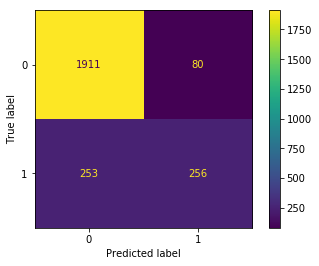

In [17]:
conf_matrix_plot(xgb_cv, X_test, y_test)

From the 2,500 people in our test data, there are 509 customers who left the bank. Of those, our model captures 256. The confusion matrix indicates that, when the model makes an error, it’s usually a Type II error—it gives a false negative by failing to predict that a customer will leave. On the other hand, it makes far fewer Type I errors, which are false positives.

Ultimately, whether these results are acceptable depends on the costs of the measures taken to prevent a customer from leaving versus the value of retaining them. In this case, bank leaders may decide that they’d rather have more true positives, even if it means also capturing significantly more false positives. If so, perhaps optimizing the models based on their F1 scores is insufficient. Maybe we’d prioritize a different evaluation metric.

One way to modify the decision-making without retraining the model is to adjust the threshold at which the model predicts a positive response. In other words, the model determines a probability that a given customer will churn. By default, if that probability is ≥ 0.50, then the model will label that customer as churned. Probabilities of < 0.50 would designate a non-responder. But it's possible to adjust this decision threshold. For instance, if we set the threshold to 0.25, then the model would label customers with predicted probabilities ≥ 0.25 as churned, and those with probabilities < 0.25 as not churned. This would increase the recall of the model, but decrease the accuracy.

In any case, what is certain is that our model helps the bank. Consider the results if decision-makers had done nothing. In that case, they’d expect to lose 509 customers. Alternatively, they could give everybody an incentive to stay. That would cost the bank for each of the 2,500 customers in our test set. Finally, the bank could give incentives at random—say, by flipping a coin. Doing this would incentivize about the same number of true responders as our model selects. But the bank would lose a lot of money offering the incentives to people who aren’t likely to leave, and our model is very good at identifying these customers.

Feature importance

The XGBoost library has a function called plot_importance, which we imported at the beginning of this notebook. This let's us check the features selected by the model as the most predictive. We can create a plot by calling this function and passing to it the best estimator from our grid search.

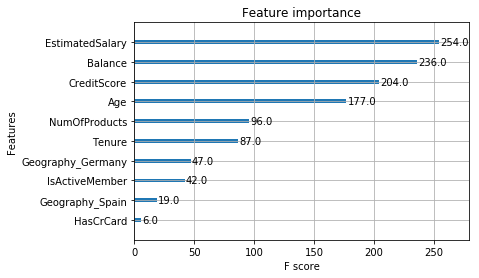

In [18]:
plot_importance(xgb_cv.best_estimator_);

This tells us that the four most important features used by our model were EstimatedSalary, Balance, CreditScore, and Age. This is very useful information. In a full project, we'd go back and examine these features very closely to understand how and why they are affecting churn.

At this point, it would also be a good idea to go back and add the model predictions and Gender feature to each sample in our data. Then we could examine how evenly the model distributes its error across reported gender identities.

A reminder about modeling trade-offs

Remember, the decision to use only the champion model to predict on the test data comes with a trade-off. The benefit is that we get a true idea of how we'd expect the model to perform on new, unseen data. The cost of this decision is that, by using the validation scores to both tune hyperparamters and select the champion model, we run the risk of selecting the model that most overfit the validation data.

Alternatively, we could have selected our champion model by using all of our tuned models to predict on the test data and choosing the one that performed best. That also would have come with a trade-off. There wouldn't be as much risk of overfitting to the validation data, but by using the test data to select our champion model, we wouldn't get a truly objective idea of how the model would perform on new, unseen data. We would need a new dataset for that, which means we would have had to set more data aside at the beginning, resulting in less data to use to train the model.

With sufficient data, a more rigorous approach would be:

1. Split the data into training, validation, and test sets
2. Tune hyperparameters using cross-validation on the training set
3. Use all tuned models to predict on the validation set
4. Select a champion model based on performance on the validation set
5. Use champion model alone to predict on test data

Every modeling decision comes with a trade-off. What's most important is that you're aware of the trade-offs and apply the best reasoning to the task at hand.

More rigorous approach: